<a href="https://colab.research.google.com/github/leanneFeng/FengLei/blob/main/Reddit_Practical1_131123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SOST60511 Understanding Big Data 2023-24 1st Semester - Practical 1

This python script is a free software licensed under the [GNU General Public License v3.0 or any later version](https://www.gnu.org/licenses/gpl-3.0.txt). You can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This script is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

## Copyright © 2023 Md Mushtahid Salam and Jihye Kim.



# 1. Why Python and Google Colab?

Python is an open-source programming language, similar to R. This means that a vast number of third-party packages or libraries can extend Python's functionality. Today, we'll be using Python and some third-party packages to collect and analyze Reddit  data.
Google Colaboratory, or Colab for short, is a free, web-based platform provided by Google that allows you to write, run, and share Python code in interactive Jupyter notebooks. It offers an easy-to-use environment with built-in collaboration features, access to powerful computing resources, and seamless integration with Google Drive. Colab is an excellent tool for students to learn, experiment, and collaborate on coding projects—all you need is a Google account and an internet connection, regardless of which OS you use.
This session is not a comprehensive Python tutorial, as that is beyond the scope of this tutorial. However, we will discuss how we can use Python to analyze your research question using Reddit data. More practically, we will focus on which parameters or variables you need to change in this script to obtain your Reddit data.
I have added comments within the code to make it easy for you to understand what the code is doing. Short comments are preceded by a single #, and long comments are enclosed with triple quotes (''' ''').
Important: The variables you NEED to change according to your research are preceded by five #s, e.g., #####
Variables that you may want to modify (not essential) are indicated by 3 #s, e.g., ###

## How to run the code?

---



---



---


To execute a cell in Google Colab, simply click on the cell you want to run, and then press the play button (▶️) that appears on the left side of the cell. Alternatively, you can use the keyboard shortcut Shift + Enter to run the currently selected cell. Once the cell is executed, the output will be displayed below the cell, and the focus will move to the next cell in the notebook.

# Objectives of Practical 1

---
---
---


1. Data collection
2. Make a subset
3. Data cleaning

## 2. Install and Load packages
---
---


In [1]:
!pip install praw # for accessing and collecting Reddits
!pip install pandas # to create dataframes or tables
!pip install wordcloud # to find the Top keywords and Top Hashtags
!pip install emoji # to detect emojis
!pip install matplotlib # to create plots
!pip install fasttext # to detect reddit posts in english language only. there are other packages https://stackoverflow.com/questions/39142778/how-to-determine-the-language-of-a-piece-of-text/47106810#47106810

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199773 sha256=b542c1f45490b4d7b6329d0a6fbb20483af8bcff7abcd704fee2f1c179434c71
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [2]:
# Download the language model
'''
We are using the compressed version of the language model,
but if you want you can download the slighly more accurate but much larger (in terms of size) model
from here: https://fasttext.cc/docs/en/language-identification.html
'''
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz



--2023-11-30 09:07:55--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.51, 18.173.166.48, 18.173.166.74, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 938013 (916K) [binary/octet-stream]
Saving to: ‘lid.176.ftz’

lid.176.ftz         100%[===================>] 916.03K  --.-KB/s    in 0.1s    

2023-11-30 09:07:55 (7.11 MB/s) - ‘lid.176.ftz’ saved [938013/938013]



In [3]:
# Load packages
import praw
import pandas as pd
from datetime import datetime # for datetime variable
import matplotlib.pyplot as plt
from wordcloud import WordCloud # to generate the wordclouds
from wordcloud import STOPWORDS # to create the list of excluded words during frequency analysis
import fasttext # for language detection, in our case, english
import collections # to count keywords and hashtags
import emoji
import re # regular expressions
import time # to respect API rate limit

In [4]:
# Set up language detection
# Load the pre-trained language detection model (compressed version)
lang_model = fasttext.load_model('lid.176.ftz')

# Define function to predict language using fasttext
def is_english(text):
    text = text.replace('\n', ' ').replace('\r', ' ') # Remove newlines before passing the text to the model, or else fasttext will throw up an error
    predictions = lang_model.predict(text, k=1)  # k=1 means we only want the top 1 prediction
    lang = predictions[0][0]  # predictions are in the format (('label',), array([confidence]))
    return lang == '__label__en'  # Check if the top prediction is English

# Ignore the warning below!

# 3. Access Reddit API
---
---

In [5]:
# Create a Reddit instance with your API credentials
reddit = praw.Reddit(client_id='PxLXi7rFLUMDBFY7xWq5tg', client_secret='aLCumPU5dOHDpQek8wHbVK7D1xmaxg', user_agent='SSlena')



# 4. Data Collection
---
---

## 4.1. Collect main text

In [6]:
##### Define your search query
keyword = '"Human Papillomavirus", "HPV", "Cervical Cancer"'
# https://www.makeuseof.com/tag/right-way-search-reddit/ - COULD BE USEFUL.

### Define the number of posts you want to collect overall
num_posts_to_collect = 500  # Adjust as needed. Maybe not more than 1000 at a time as per https://www.mdpi.com/2076-3417/13/4/2250


# Lists to store data for posts and comments
posts_data = []
comments_data = []

'''
The following regular expression and minimum comment length is designed to
remove comments that only contain URLS and/or are just short comments which
doesn't add much to the discussion (for example a simple "yes"). The both of them together:
if a comment contains a URL, the URL will be removed, and after that if the
comment contains substantial text (determined by the minimum comment length),
the comment will remain, otherwise filtered out. Additionally,
any comment with a character length below the specified limit will also be filtered out.
Remember however, this is just us filtering the comments based on the above conditions.
At the end the comments that we will keep, however, will still remain the URLs, although
we could, if we wanted, keep the URL free versions. But we will be processing the URLs
afterwards anyway before keyword and sentiment analysis.
'''
# Regular expression for detecting URLs
url_regex = re.compile(
    r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
)
##### Minimum length of comment content to be considered substantial
min_comment_length = 20 # Set the character length as desired. What makes a good character length for comments?

# Search keywords
for submission in reddit.subreddit('all').search(keyword, limit=num_posts_to_collect):

    # Check if it's a selftext (and not just images/links) and not deleted/removed
    # and check if title and post is in english
    if submission.is_self and submission.selftext not in ["[deleted]", "[removed]"] \
    and is_english(submission.title + ' ' + submission.selftext):
        # Store post data
        posts_data.append({ # This doesn't contain all the attributes you added above. But they can be easily added.
            'Post_ID': submission.id,
            'Title': submission.title,
            'Content': submission.selftext,
            'URL': submission.url,
            'Subreddit': submission.subreddit.display_name,
            'Date': datetime.utcfromtimestamp(submission.created_utc).strftime('%Y-%m-%d %H:%M:%S')
        })

        ### Fetch comments for this post
        '''
        # Limit to 5 "more comments" expansions for a post. Adjust as necessary!
        But the more, ther higher the risk of hitting the rate limit.
        Maybe increase the sleep time below if collecting more data if you keep
        hitting the rate limit!
        '''
        # submission.comments.replace_more(limit=None)  # Get all comments.
        submission.comments.replace_more(limit=5) # You may want to fetch more commetns
        for comment in submission.comments.list():

            # Filter out removed/deleted comments and non-english comments.
            if comment.body not in ["[deleted]", "[removed]"] and is_english(comment.body):

                # Remove URLs from the comment body
                comment_text_without_urls = url_regex.sub('', comment.body)

                # Check if comment text without URLs is not just whitespace and is of substantial length
                if comment_text_without_urls.strip() and len(comment_text_without_urls) >= min_comment_length:
                    comments_data.append({
                        'Post_ID': submission.id,  # To link to which post it is coming from.
                        'Comment_id': comment.id,
                        'Content': comment.body,  # If you want the URL-free text, use comment_text_without_urls here
                        'Date': datetime.utcfromtimestamp(submission.created_utc).strftime('%Y-%m-%d %H:%M:%S')
                    })

        ### Introduce a 5-second delay before processing the next post.
        ### Maybe increase it more for larger data collection!
        time.sleep(5)


# At this point:
# 'posts_data' list contains details of each post.
# 'comments_data' list contains all comments with submission.id as a reference to the post

# Convert the lists to DataFrames
posts_df = pd.DataFrame(posts_data)
comments_df = pd.DataFrame(comments_data)

print(posts_df.head())
print(comments_df.head())

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

   Post_ID                                              Title  \
0  17vgsi1  Is anyone else in disbelief that METAL speculu...   
1   qnw8zu  HPV vaccine reduced cervical cancer rates by 8...   
2  15s2orw  Stayed at a hotel and told the driver to park ...   
3   rg4qpe  If you could steal one quality from the opposi...   
4  13qnstq                             Information about HPV!   

                                             Content  \
0  I saw an article recently about concerns that ...   
1  (Source: CNN)\n\nWatch the video in our channe...   
2  I was staying at big hotel by Disneyland and i...   
3                                                      
4  Hey everyone! My name is Tobi and I’m a medica...   

                                                 URL          Subreddit  \
0  https://www.reddit.com/r/TwoXChromosomes/comme...    TwoXChromosomes   
1  https://www.reddit.com/r/the_news_of_today/com...  the_news_of_today   
2  https://www.reddit.com/r/doordash/comments/1

In [ ]:
# See the post df
posts_df

,Post_ID,Title,Content,URL,Subreddit,Date
0,k81xnp,Megathread: Rudy Giuliani Tests Positive for C...,President Trump’s personal attorney Rudy Giuli...,https://www.reddit.com/r/politics/comments/k81...,politics,2020-12-06 20:58:16
1,fn465t,Megathread: Senator Rand Paul tests positive f...,Senator Rand Paul announced he has tested posi...,https://www.reddit.com/r/politics/comments/fn4...,politics,2020-03-22 18:14:07
2,kijhuc,Megathread: President Trump Threatens to Veto ...,"President Donald Trump, in a Tuesday night twe...",https://www.reddit.com/r/politics/comments/kij...,politics,2020-12-23 01:54:32
3,j6gfo6,Megathread: Top White House Aide Stephen Mille...,"""Over the last 5 days I have been working remo...",https://www.reddit.com/r/politics/comments/j6g...,politics,2020-10-06 23:51:57
4,gdeglb,Conflicting CDC statistics on US Covid-19 deat...,"Hello,\n\nThere’s been some conflicting inform...",https://www.reddit.com/r/askscience/comments/g...,askscience,2020-05-04 16:12:56
5,p6d6vm,Megathread: Texas Governor Abbott Tests Positi...,Texas Governor Greg Abbott tested positive for...,https://www.reddit.com/r/politics/comments/p6d...,politics,2021-08-17 21:38:55
6,fh8mvt,Megathread: Trump Suspends European Travel to ...,President Trump announced in an Oval Office ad...,https://www.reddit.com/r/politics/comments/fh8...,politics,2020-03-12 01:48:06
7,j4j8m6,U.S. Political Figures COVID-19 Megathread,This megathread is for discussing all news rel...,https://www.reddit.com/r/Coronavirus/comments/...,Coronavirus,2020-10-03 17:37:00
8,mvicaw,Doctors of Reddit: What happened when you diag...,,https://www.reddit.com/r/AskReddit/comments/mv...,AskReddit,2021-04-21 15:38:33
9,fbvz7n,COVID-19 Megathread #4,**This post is updated daily.**\n\n&nbsp;\n\nC...,https://www.reddit.com/r/news/comments/fbvz7n/...,news,2020-03-01 16:00:23


In [ ]:
# See the comments df
comments_df

,Post_ID,Comment_id,Content,Date
0,k81xnp,gevge6e,"Do not threaten, advocate for, wish, hope, cel...",2020-12-06 20:58:16
1,k81xnp,gevgg5r,https://twitter.com/kylegriffin1/status/133569...,2020-12-06 20:58:16
2,k81xnp,gevg4me,The only thing that’s surprising here is that ...,2020-12-06 20:58:16
3,k81xnp,gevgqk5,Reports say he's checking in to Walter Reed He...,2020-12-06 20:58:16
4,k81xnp,gevg995,Video of Giuliani asking his witness at his MI...,2020-12-06 20:58:16
...,...,...,...,...
16715,16ookrs,k1nifwr,Perforated ischemic bowel infarction leading t...,2023-09-21 19:17:22
16716,16ookrs,k1nipoa,"I got all my shots, as every normal guy would....",2023-09-21 19:17:22
16717,16ookrs,k1ngbhr,I literally don't understand you lol. Disengag...,2023-09-21 19:17:22
16718,16ookrs,k1ng1ru,I never said any of that was acceptable. He sh...,2023-09-21 19:17:22


# 5. Save the Data
---
---

## 5.1. Save the data as a CSV file

In [7]:
# Save the DataFrame as a CSV file
# Load the saved file so you don't have to always re-run the data collection.
# If you are coming back to this analysis and have a csv file downloaded on your computer, click on Files, and just drag and
# drop (or use the upload to session storage button) the csv file there. Make sure the uploaded file has the same name as the code below.
# If not change either the file name or the code below.
posts_df.to_csv('reddit_posts.csv', encoding='utf-8')

comments_df.to_csv('reddit_comments.csv', encoding='utf-8')

## 5.2. Load the saved csv file



Click on the files button on the left 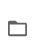. You should see the file there and be able to download the file from there.

When you are re-running the analysis for any reason, just upload the file from your computer to the Files section. This way you don't have to run all the codes to collect and get the data (Just run the two blocks in Section 2 to install and load the packages and then start from this block)

In [8]:
# Load the saved files
posts_df_loaded = pd.read_csv('reddit_posts.csv', encoding='utf-8')
comments_df_loaded = pd.read_csv('reddit_comments.csv', encoding='utf-8')

'''
If you get an error, try the following code. make sure to comment out the code above (add # before the code)
and uncomment  the code below (remove # before the code) before running
'''
# df = pd.read_csv('reddit.csv', encoding='utf-8', lineterminator='\n')

'\nIf you get an error, try the following code. make sure to comment out the code above (add # before the code)\nand uncomment  the code below (remove # before the code) before running\n'

In [9]:
# See the dataframes we just loaded from the saved file
# To avoid unnamed: 0 column, we have to save the csv files with index=False or load the files with index_col=0, neither of which we did. Anyway it doesn't matter.
posts_df_loaded

,Unnamed: 0,Post_ID,Title,Content,URL,Subreddit,Date
0,0,17vgsi1,Is anyone else in disbelief that METAL speculu...,I saw an article recently about concerns that ...,https://www.reddit.com/r/TwoXChromosomes/comme...,TwoXChromosomes,2023-11-15 00:24:48
1,1,qnw8zu,HPV vaccine reduced cervical cancer rates by 8...,(Source: CNN)\n\nWatch the video in our channe...,https://www.reddit.com/r/the_news_of_today/com...,the_news_of_today,2021-11-06 08:45:13
2,2,15s2orw,Stayed at a hotel and told the driver to park ...,I was staying at big hotel by Disneyland and i...,https://www.reddit.com/r/doordash/comments/15s...,doordash,2023-08-15 19:41:44
3,3,rg4qpe,If you could steal one quality from the opposi...,NaN,https://www.reddit.com/r/AskMen/comments/rg4qp...,AskMen,2021-12-14 10:33:25
4,4,13qnstq,Information about HPV!,Hey everyone! My name is Tobi and I’m a medica...,https://www.reddit.com/r/queer/comments/13qnst...,queer,2023-05-24 14:48:38
5,5,ogw4v3,[Discussion] If your collection has a luxury w...,"It's not. Calling it that makes you, and by ex...",https://www.reddit.com/r/Watches/comments/ogw4...,Watches,2021-07-09 13:59:28
6,6,120qztl,"Getting called ""Rat"" , ""Lineup larry"" and ""Cri...",I just came back from a 2 year hiatus and for ...,https://www.reddit.com/r/VALORANT/comments/120...,VALORANT,2023-03-24 17:12:33
7,7,16it0o0,WTF?!? Just shred or cut the little muppet ali...,"I’m kinda being an ass , I know. But seriously...",https://www.reddit.com/r/aliens/comments/16it0...,aliens,2023-09-14 20:30:46
8,8,7kxur3,"Girlfriend likely got HPV from me, now has ear...",I met my girlfriend about half a year ago when...,https://www.reddit.com/r/sex/comments/7kxur3/g...,sex,2017-12-20 01:10:21
9,9,135ix5a,How many of you are an absolute gun at work bu...,NaN,https://www.reddit.com/r/adhdwomen/comments/13...,adhdwomen,2023-05-02 11:54:29


In [10]:
comments_df_loaded

,Unnamed: 0,Post_ID,Comment_id,Content,Date
0,0,17vgsi1,k9aqr5k,"metal can go through an autoclave, i trust it ...",2023-11-15 00:24:48
1,1,17vgsi1,k9aj4z0,The metal speculum doesn’t really bother me. I...,2023-11-15 00:24:48
2,2,17vgsi1,k9araih,FYI they don’t open your cervix. They spread ...,2023-11-15 00:24:48
3,3,17vgsi1,k9at26m,The metal ones are too heavy when they just le...,2023-11-15 00:24:48
4,4,17vgsi1,k9asebh,I prefer the metal ones because the cheap plas...,2023-11-15 00:24:48
...,...,...,...,...,...
11295,11295,122zair,jdw8rfm,I couldn't get it in the USA. Joined peace cor...,2023-03-26 20:55:29
11296,11296,122zair,jdtzd93,"Yeah, that was my own experience. It's just no...",2023-03-26 20:55:29
11297,11297,122zair,jdtz8g8,I mean jesus also apparently wants 12 year old...,2023-03-26 20:55:29
11298,11298,122zair,jdzim2p,In Australia they had it free for age 12 - 20 ...,2023-03-26 20:55:29


## 5.3 Drop missing/empty contents

In [11]:
# Having missing itemts means we will run into errors! So we need to drop rows that contain missing contents.

# Print the number of rows before deleting missing contents
print("Number of rows before deleting missing posts:", posts_df_loaded.shape[0])

# Drop the rows with missing contents
posts_df_loaded.dropna(subset=['Content'], inplace=True)
posts_df_loaded.reset_index(drop=True, inplace=True)

# Print the number of rows after deleting missing contents
print("Number of rows after deleting missing posts:", posts_df_loaded.shape[0])

# If no change, that means you didn't have any missing contents in your data.




Number of rows before deleting missing posts: 38
Number of rows after deleting missing posts: 27


In [12]:
# Do the same for comments
# Having missing itemts means we will run into errors! So we need to drop rows that contain missing contents.

# Print the number of rows before deleting missing contents
print("Number of rows before deleting missing comments:", comments_df_loaded.shape[0])

# Drop the rows with missing contents
comments_df_loaded.dropna(subset=['Content'], inplace=True)
comments_df_loaded.reset_index(drop=True, inplace=True)

# Print the number of rows after deleting missing contents
print("Number of rows after deleting missing comments:", comments_df_loaded.shape[0])

# If no change, that means you didn't have any missing contents in your data.




Number of rows before deleting missing comments: 11300
Number of rows after deleting missing comments: 11300


In [13]:
# Total number of rows in both dataframes:
posts_df_loaded.shape[0] + comments_df_loaded.shape[0]

11327

## 5.4. Merge posts and comments contents in a single dataframe

In [14]:
# For now, I am only keeping the Content column.

merged_content = pd.concat([posts_df_loaded['Content'], comments_df_loaded['Content']]).reset_index(drop=True)
merged_df = merged_content.to_frame()
print("Number of rows after merging posts and comments:", merged_df.shape[0]) # Compare with above

Number of rows after merging posts and comments: 11327


In [15]:
# See the merged_df
merged_df

,Content
0,I saw an article recently about concerns that ...
1,(Source: CNN)\n\nWatch the video in our channe...
2,I was staying at big hotel by Disneyland and i...
3,Hey everyone! My name is Tobi and I’m a medica...
4,"It's not. Calling it that makes you, and by ex..."
...,...
11322,I couldn't get it in the USA. Joined peace cor...
11323,"Yeah, that was my own experience. It's just no..."
11324,I mean jesus also apparently wants 12 year old...
11325,In Australia they had it free for age 12 - 20 ...


In [16]:
# Save merged_df
merged_df.to_csv('merged_posts_comments.csv', encoding='utf-8')


In [17]:
# Load merged_df
merged_df_loaded = pd.read_csv('merged_posts_comments.csv', encoding='utf-8')

In [18]:
# See merged_df_loaded
merged_df_loaded

,Unnamed: 0,Content
0,0,I saw an article recently about concerns that ...
1,1,(Source: CNN)\n\nWatch the video in our channe...
2,2,I was staying at big hotel by Disneyland and i...
3,3,Hey everyone! My name is Tobi and I’m a medica...
4,4,"It's not. Calling it that makes you, and by ex..."
...,...,...
11322,11322,I couldn't get it in the USA. Joined peace cor...
11323,11323,"Yeah, that was my own experience. It's just no..."
11324,11324,I mean jesus also apparently wants 12 year old...
11325,11325,In Australia they had it free for age 12 - 20 ...


# 6. Data Cleaning
---
---

## 6.1 Drop stop words

In [19]:
##### Define your list of stop words to exclude from top keywords and hashtags
##### Add words to the stop_words below that you want to exclude from top keywords and hashtags
stop_words = ['&nbsp;','*','-', '&amp;', 'a', 'an', 'the', 'in', 'on', 'at', 'for', 'of', 'with', 'to', 'and', 'is', 'are',
              'was', 'were', 'that', 'this', 'it', 'from', "it's"]

# The following code also adds stop words to your list of stop_words  from wordcloud.STOPWORDS that are not already present in stop_words
# You can view STOPWORDS excluded words by running this command print(STOPWORDS)
'''
For your reference this is what the print(STOPWORDS) would produce:
{'over', 'too', "he's", 'so', "you'll", 'they', 'own', 'does', "hadn't", 'theirs',
'with', "they'll", "weren't", 'we', 'get', 'his', 'him', 'hers', 'no', "there's",
'both', 'me', 'would', 'this', 'is', 'such', 'once', 'as', "can't", "let's", "she'd",
'have', 'which', 'about', 'and', 'are', 'only', 'again', 'most', 'while', 'her', 'out',
'on', 'or', "who's", "couldn't", 'all', 'below', 'else', 'he', 'each', "she's", "here's",
"wasn't", 'ours', 'for', 'other', 'itself', 'than', 'at', "isn't", 'off', 'further', 'then',
'should', 'from', "i'm", 'she', 'under', 'been', 'themselves', 'these', 'having', 'therefore',
'its', 'do', 'yours', 'cannot', 'since', "you're", 'shall', 'whom', 'some', 'where', "didn't",
'com', 'nor', "shan't", 'k', "shouldn't", 'that', 'very', "i've", 'same', 'were', 'did', 'their',
"he'll", 'ever', 'ought', 'through', 'above', 'but', "we're", 'because', "i'd", 'here', "aren't",
"we'd", "we'll", "why's", 'when', 'however', "what's", "i'll", 'http', "you've", "we've", "where's",
'hence', 'himself', 'of', 'more', 'doing', 'can', 'herself', 'down', 'www', 'few', 'yourself', "they've",
"hasn't", 'an', 'before', "she'll", 'into', 'be', 'in', 'like', "they're", 'also', 'why', 'our', 'my',
"won't", "haven't", 'not', 'was', 'who', 'ourselves', 'until', 'it', 'if', 'myself', 'your', 'being',
"wouldn't", 'against', "they'd", 'had', 'what', 'up', 'by', 'the', "don't", 'am', 'any', "how's",
"that's", "mustn't", 'a', 'you', 'could', 'during', 'yourselves', "he'd", 'just', "doesn't", 'them',
'r', 'otherwise', 'i', 'to', 'has', "it's", 'those', "when's", 'after', 'how', "you'd", 'there', 'between'}
'''
# If you don't want to add the STOPWORDS in your list of stop_words, just comment out the
# immeidate follwoing three lines (select and press CTRL+/ or Command+/) or just delete them.
for word in STOPWORDS:
    if word not in stop_words:
        stop_words.append(word)


# 7. Find Top Keywords
---
---

In [20]:
# Find the Top keywords

# Define a Counter object to store the word frequencies
word_freq = collections.Counter()

# Loop through each text in the DataFrame
for text in merged_df_loaded['Content']:
    # Convert the text to lowercase
    text = text.lower()

    # Replace curly apostrophes with straight ones
    text = text.replace("’", "'")
    text = text.replace("‘", "'")

    # Replace curly double quotes with straight ones
    text = text.replace("“", '"')
    text = text.replace("”", '"')

    # Remove emojis using emoji.replace_emoji()
    text = emoji.replace_emoji(text, replace='')

    # Split the text into words
    words = text.split()

    # Loop through each word in the text
    for word in words:
        # Strip any punctuation marks from the begining and end of the word
        ''' This is because we want "covid" and "covid." to be combined as "covid"
        instead of treating them as seperate words  '''
        word = word.strip('\'".,?!()[]{}')
        # Check if the word is a hashtag
        if word.startswith('#'):
            # Remove non-alphanumeric characters from the hashtag (keep . _ and -)
            word = re.sub(r'[^a-zA-Z0-9._-]+', '', word)

        # Exclude stop words and URLs
        if word and word not in stop_words and not word.startswith('http'): # To exclude stopwords and links
            # Add the word to the word frequency Counter
            word_freq[word] += 1

# Get the top 100 words
top_words = dict(word_freq.most_common(100))

print("Top 100 Words:")
print(top_words)


Top 100 Words:
{'people': 1768, 'one': 1680, 'know': 1026, 'time': 986, 'even': 938, 'think': 903, 'will': 816, 'really': 785, 'go': 749, 'hpv': 729, 'got': 723, 'still': 708, 'way': 705, 'good': 695, 'back': 694, 'much': 683, 'never': 677, 'want': 670, 'cancer': 663, 'someone': 662, 'years': 661, 'now': 659, 'make': 648, 'take': 638, 'love': 622, 'always': 597, 'lot': 580, 'something': 565, 'cart': 557, 'say': 545, 'well': 524, 'life': 510, 'work': 509, 'things': 507, 'said': 506, 'need': 495, 'see': 490, 'every': 478, 'thing': 475, 'going': 474, 'first': 473, 'feel': 464, 'right': 460, 'care': 454, 'put': 441, 'sure': 424, 'use': 422, 'find': 420, 'women': 416, 'happy': 408, 'us': 407, 'many': 404, 'better': 385, 'getting': 381, 'person': 381, 'look': 376, 'vaccine': 372, 'away': 372, 'actually': 370, 'though': 368, 'day': 366, 'watch': 360, 'around': 358, 'year': 355, 'everyone': 340, 'anything': 340, 'made': 332, 'cervical': 330, 'two': 323, 'best': 318, 'give': 315, 'probably': 31

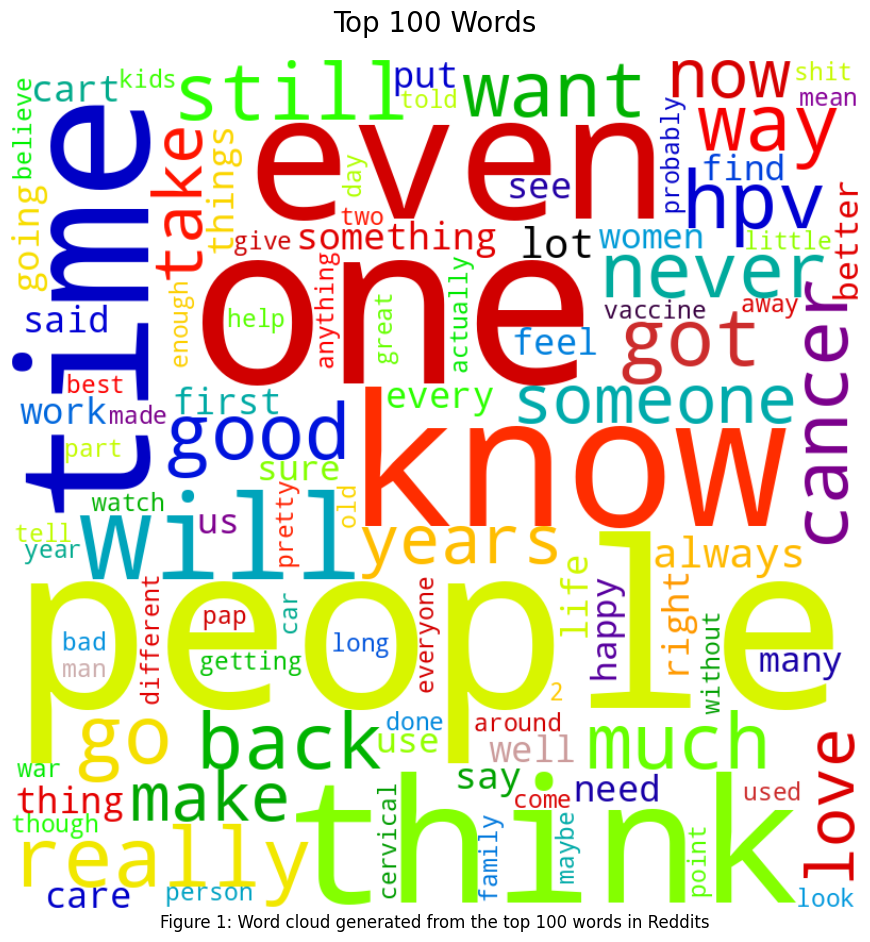

In [21]:
# Combined top 100 words based on absolute frequency
# Combine top words and hashtags into a single string
text = top_words

# Count the occurrence of each word in the combined text
word_freq = collections.Counter(text)

# Generate the word cloud, including only the top words and hashtags
### You can play with the parameters (colormap, min_font_size, background_color) below to see what happens!
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=15000, min_font_size=5,
                      collocations=False, colormap='nipy_spectral').generate_from_frequencies(word_freq)

# Display the word cloud
### You can play around with the figsize, fontsize below
plt.figure(figsize=(9, 9), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

##### Change the title accordingly
plt.title("Top 100 Words", fontsize=20, pad=20)

##### Change the caption accordingly
plt.figtext(0.5, -0.02, "Figure 1: Word cloud generated from the top 100 words in Reddits",
            ha="center", fontsize=12)
plt.tight_layout(pad=0)
plt.savefig("Top_100_words.png", dpi=300, bbox_inches='tight')
plt.show()

# 8. Filter data based on sub-keywords

In [28]:
##### Define the subKeywords based on the frequency analysis and filter the data

# Note: In this section we have to use | to represent OR, & to represent AND

'''
This following example essenitally filters based on this:
(('vaccine' OR 'vaccination' OR 'vaccinations') AND ('Gardasil 9' OR 'Gardasil' OR 'Cervarix'))
'''

# Let's build the subKeywords first:
##### subKeywords: ('vaccine' OR 'vaccination' OR 'vaccinations') AND ('Gardasil 9' OR 'Gardasil' OR 'Cervarix')
# Let's break down each of the three filters within brackets that are joined by AND in the example above
firstKey_filter = merged_df_loaded['Content'].str.contains('vaccine | vaccination | vaccinations', case=False, na=False, regex=True) # | represents OR
secondKey_filter = merged_df_loaded['Content'].str.contains('Gardasil 9 | Gardasil | Cervarix', case=False, na=False, regex=True)
# subKeywords_filter: Finally join the two filters using AND
subKeywords_filter = firstKey_filter & secondKey_filter # & represents AND

'''
NOTE: You might not need all three filters for your subKeywords or subHashtags. Or maybe you need more! Edit the code accordingly.
e.g. if you need only one firstKey_filter, then just delete the other two and make sure you also update your
subKeywords_filter (e.g., if you just have the firstKey_filter (which could be something like mask | vaccine),
then subKeywords_filter = firstKey_filter). Do the same for subHashtags
'''

# Finally filter the DataFrame based on the subkeywords
filtered_df = merged_df_loaded[subKeywords_filter]

# Create a new column with the original index values
filtered_df.insert(0, 'Original Index', filtered_df.index)
# Reset the index
filtered_df = filtered_df.reset_index(drop=True)

# Get the number of filtered rows
print("Number of filtered conent: ", filtered_df.shape[0])

Number of filtered conent:  16


In [29]:
# See the filtered dataframe
filtered_df

,Original Index,Unnamed: 0,Content
0,1,1,(Source: CNN)\n\nWatch the video in our channe...
1,10,10,The announcement is in stark contrast to the p...
2,12,12,"By [Gérard Delépine, MD](https://www.agoravox...."
3,26,26,I saw something on social media that seemed to...
4,3431,3431,>Most are harmless and only 4 (as far as we kn...
5,6911,6911,"it's going to take more time, since HPV\-relat..."
6,8082,8082,Thank you for your response - that makes sense...
7,8694,8694,I had such a scary experience when I was 19. W...
8,8867,8867,Thank you! When I was 15-ish I got a vaccine n...
9,8891,8891,I had Gardasil and still ended up with CINIII ...


In [30]:
# As always, save the dataframe! Make sure to download it to your computer!
filtered_df.to_csv('filtered_content.csv', index=False)
# filtered_df.info()

In [31]:
# Load the filtered data so you don't always have to re-run the above codes to get it
filtered_df_loaded = pd.read_csv('filtered_content.csv', encoding='utf-8')
# filtered_df['created_at'] = pd.to_datetime(filtered_df.created_at)
# filtered_df.info() # All looks good!

In [32]:
# Find the Top keywords of subset

# Define a Counter object to store the word frequencies
word_freq = collections.Counter()

# Loop through each text in the DataFrame
for text in filtered_df_loaded['Content']:
    # Convert the text to lowercase
    text = text.lower()

    # Replace curly apostrophes with straight ones
    text = text.replace("’", "'")
    text = text.replace("‘", "'")

    # Replace curly double quotes with straight ones
    text = text.replace("“", '"')
    text = text.replace("”", '"')

    # Remove emojis using emoji.replace_emoji()
    text = emoji.replace_emoji(text, replace='')

    # Split the text into words
    words = text.split()

    # Loop through each word in the text
    for word in words:
        # Strip any punctuation marks from the begining and end of the word
        ''' This is because we want "covid" and "covid." to be combined as "covid"
        instead of treating them as seperate words  '''
        word = word.strip('\'".,?!()[]{}')
        # Check if the word is a hashtag
        if word.startswith('#'):
            # Remove non-alphanumeric characters from the hashtag (keep . _ and -)
            word = re.sub(r'[^a-zA-Z0-9._-]+', '', word)

        # Exclude stop words and URLs
        if word and word not in stop_words and not word.startswith('http'): # To exclude stopwords and links
            # Add the word to the word frequency Counter
            word_freq[word] += 1

# Get the top 100 words
top_words = dict(word_freq.most_common(100))

print("Top 100 Words:")
print(top_words)

Top 100 Words:
{'cancer': 79, 'cervical': 59, 'hpv': 50, 'vaccine': 43, 'vaccination': 41, 'incidence': 30, 'gardasil': 24, 'vaccinated': 19, 'vaccines': 19, 'women': 16, 'one': 15, 'mortality': 13, 'even': 12, 'years': 12, 'invasive': 12, 'cancers': 11, 'risk': 11, 'cases': 10, 'new': 10, 'coverage': 10, 'cin': 10, 'rates': 9, 'health': 9, 'many': 9, 'mps': 9, 'increase': 9, 'countries': 9, 'smear': 9, 'screening': 9, '2017': 9, 'study': 8, 'strains': 8, 'got': 8, 'still': 8, '2': 8, 'high': 8, 'effective': 8, 'almost': 8, 'uk': 7, '18': 7, 'said': 7, 'deaths': 7, 'will': 7, 'cervix': 7, 'according': 7, '3': 7, '2006': 6, 'human': 6, 'papillomavirus': 6, '16': 6, 'rate': 6, 'first': 6, 'results': 6, 'young': 6, 'girls': 6, 'doctors': 6, '2015': 6, 'sometimes': 6, 'time': 6, 'number': 6, 'france': 6, 'sexually': 6, 'active': 6, 'people': 6, 'getting': 6, 'reduced': 5, 'cervarix': 5, 'three': 5, 'age': 5, 'evidence': 5, 'campaign': 5, 'prevention': 5, 'efficacy': 5, 'early': 5, 'related

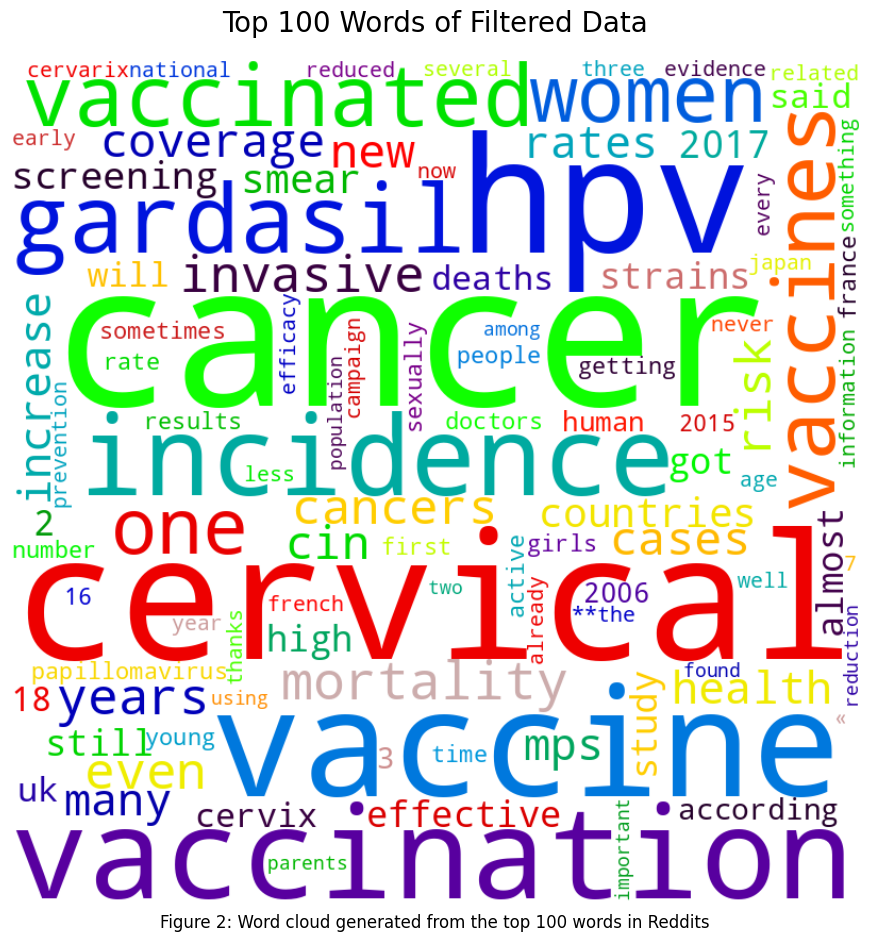

In [33]:
# Combined top 100 words based on absolute frequency
# Combine top words and hashtags into a single string
text = top_words

# Count the occurrence of each word in the combined text
word_freq = collections.Counter(text)

# Generate the word cloud, including only the top words and hashtags
### You can play with the parameters (colormap, min_font_size, background_color) below to see what happens!
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=15000, min_font_size=5,
                      collocations=False, colormap='nipy_spectral').generate_from_frequencies(word_freq)

# Display the word cloud
### You can play around with the figsize, fontsize below
plt.figure(figsize=(9, 9), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

##### Change the title accordingly
plt.title("Top 100 Words of Filtered Data", fontsize=20, pad=20)

##### Change the caption accordingly
plt.figtext(0.5, -0.02, "Figure 2: Word cloud generated from the top 100 words in Reddits",
            ha="center", fontsize=12)
plt.tight_layout(pad=0)
plt.savefig("Top_Filtered.png", dpi=300, bbox_inches='tight')
plt.show()